In [1]:
import MagmaSatPlus as msp
from thermoengine import equilibrate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from ipywidgets import * # not needed for now
%matplotlib inline

In [2]:
#Create a Modeller object where the user defines the model name and version to use for calculatinos
model = msp.Modeller('MagmaSat','1.2.0') #this can take several seconds

#Import excel file
myfile = msp.ExcelFile('MagmaSat2018-input-molpercent.xlsx', input_type='molpercent') #Enter your filename here
data = myfile.data

## Plotting degassing paths

In [3]:
#One sample at a time, since I am having trouble getting multiple samples to work

#Closed and Open system can be calculated

#CLOSED SYSTEM (default?)

#----------------PREAMBLE--------------#
#Create a Modeller object where the user defines the model name and version to use for calculatinos
model = msp.Modeller('MagmaSat','1.2.0')
melts = equilibrate.MELTSmodel('1.2.0')

#Set only Fluid and Liquid phases to True
phases = melts.get_phase_names()
oxides = melts.get_oxide_names()
b = melts.get_phase_inclusion_status()
for phase in phases:
    melts.set_phase_inclusion_status({phase:False})

#set only Fluid and Liquid to True
melts.set_phase_inclusion_status({'Fluid':True, 'Liquid':True})

#Define your bulk composition
bulk_comp = {'SiO2':  77.5, 
               'TiO2':   0.08, 
               'Al2O3': 12.5, 
               'Fe2O3':  0.207,
               'Cr2O3':  0.0, 
               'FeO':    0.473, 
               'MnO':    0.0,
               'MgO':    0.03, 
               'NiO':    0.0, 
               'CoO':    0.0,
               'CaO':    0.43, 
               'Na2O':   3.98, 
               'K2O':    4.88, 
               'P2O5':   0.0, 
               'H2O':    5.0,
               'CO2':    0.5}

feasible = melts.set_bulk_composition(bulk_comp)

temp = 900.0

data = model.calculate_saturation_pressure(bulk_comp, temp)
data

{'Al2O3': 12.5,
 'CO2': 0.5,
 'CO2fluid_wtper': 86.9683672919035,
 'CaO': 0.43,
 'CoO': 0.0,
 'Cr2O3': 0.0,
 'Fe2O3': 0.207,
 'FeO': 0.473,
 'FluidMassAtSaturation_grams': 0.000231070139826164,
 'H2O': 5.0,
 'H2Ofluid_wtper': 13.0316327080965,
 'K2O': 4.88,
 'MgO': 0.03,
 'MnO': 0.0,
 'Na2O': 3.98,
 'NiO': 0.0,
 'P2O5': 0.0,
 'SaturationPressure_MPa': 902.0,
 'SiO2': 77.5,
 'TiO2': 0.08}

    pressure    H2Oliq    CO2liq      H2Ofl      CO2fl  fluid_wtper
0      911.0  4.735745  0.473575   0.000000   0.000000     0.000000
1      901.0  4.735668  0.472769  13.043520  86.956480     0.000932
2      891.0  4.735066  0.466609  13.163775  86.836225     0.008065
3      881.0  4.734445  0.460456  13.286605  86.713395     0.015209
4      871.0  4.733805  0.454312  13.412109  86.587891     0.022364
5      861.0  4.733144  0.448174  13.540387  86.459613     0.029532
6      851.0  4.732464  0.442043  13.671546  86.328454     0.036714
7      841.0  4.731761  0.435917  13.805698  86.194302     0.043911
8      831.0  4.731036  0.429797  13.942959  86.057041     0.051126
9      821.0  4.730287  0.423681  14.083453  85.916547     0.058360
10     811.0  4.729514  0.417569  14.227307  85.772693     0.065614
11     801.0  4.728714  0.411462  14.374657  85.625343     0.072891
12     791.0  4.727889  0.405357  14.525644  85.474356     0.080191
13     781.0  4.727035  0.399255  14.680418  85.

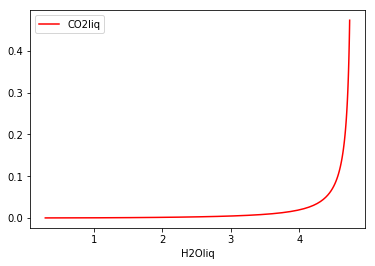

In [4]:
#closed system
P_array = np.arange(1.0, data['SaturationPressure_MPa']+10.0, 10)
P_array = -np.sort(-P_array)
output = melts.equilibrate_tp(temp, P_array)

pressure = []
H2Oliq = []
CO2liq = []
H2Ofl = []
CO2fl = []
fluid_wtper = []
for i in range(len(output)):
    (status, temp, p, xmlout) = output[i]
    liq_comp = melts.get_composition_of_phase(xmlout, phase_name='Liquid')
    fl_comp = melts.get_composition_of_phase(xmlout, phase_name='Fluid')
    liq_mass = melts.get_mass_of_phase(xmlout, phase_name='Liquid')
    fl_mass = melts.get_mass_of_phase(xmlout, phase_name='Fluid')
    fl_wtper = 100 * fl_mass / (fl_mass+liq_mass)
    
    pressure.append(p)
    H2Oliq.append(liq_comp["H2O"])
    CO2liq.append(liq_comp["CO2"])
    try:
        H2Ofl.append(fl_comp["H2O"])
    except:
        H2Ofl.append(0)
    try:
        CO2fl.append(fl_comp["CO2"])
    except:
        CO2fl.append(0)
    fluid_wtper.append(fl_wtper)


degassing_df = pd.DataFrame(list(zip(pressure, H2Oliq, CO2liq, H2Ofl, CO2fl, fluid_wtper)), 
                            columns =['pressure', 'H2Oliq', 'CO2liq', 'H2Ofl', 'CO2fl', 'fluid_wtper'])

print(degassing_df)
degassing_df.plot(kind='line',x='H2Oliq',y='CO2liq',color='red')
plt.show()


    pressure    H2Oliq        CO2liq      H2Ofl      CO2fl  fluid_wtper
0      901.0  4.735668  4.727688e-01  13.043520  86.956480     0.000932
1      851.0  4.497270  4.432829e-01  12.591313  87.408687     0.006600
2      811.0  4.282117  4.203136e-01  12.105265  87.894735     0.002033
3      771.0  4.086374  3.976532e-01  11.695917  88.304083     0.003955
4      731.0  3.907586  3.752544e-01  11.357134  88.642866     0.005712
5      701.0  3.744170  3.588239e-01  10.956425  89.043575     0.000838
6      671.0  3.593688  3.424851e-01  10.611540  89.388460     0.002169
7      641.0  3.454699  3.262262e-01  10.318112  89.681888     0.003397
8      611.0  3.325968  3.100345e-01  10.072913  89.927087     0.004535
9      581.0  3.206430  2.938973e-01   9.873745  90.126255     0.005598
10     561.0  3.095573  2.833996e-01   9.577287  90.422713     0.000376
11     541.0  2.992006  2.729004e-01   9.315928  90.684072     0.001133
12     521.0  2.895052  2.624008e-01   9.087184  90.912816     0

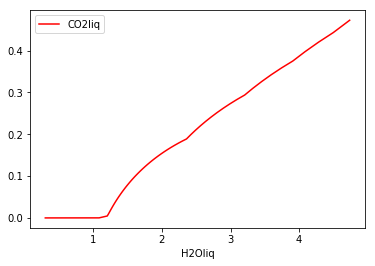

In [4]:
#open system
P_array = np.arange(1.0, data['SaturationPressure_MPa']+10.0, 10)
P_array = -np.sort(-P_array)

pressure = []
H2Oliq = []
CO2liq = []
H2Ofl = []
CO2fl = []
fluid_wtper = []
for i in P_array:
    output = melts.equilibrate_tp(temp, i)
    (status, temp, p, xmlout) = output[0]
    liq_comp = melts.get_composition_of_phase(xmlout, phase_name='Liquid')
    fl_comp = melts.get_composition_of_phase(xmlout, phase_name='Fluid')
    liq_mass = melts.get_mass_of_phase(xmlout, phase_name='Liquid')
    fl_mass = melts.get_mass_of_phase(xmlout, phase_name='Fluid')
    fl_wtper = 100 * fl_mass / (fl_mass+liq_mass)
    
    if fl_mass > 0:
        pressure.append(p)
        H2Oliq.append(liq_comp["H2O"])
        CO2liq.append(liq_comp["CO2"])
        try:
            H2Ofl.append(fl_comp["H2O"])
        except:
            H2Ofl.append(0)
        try:
            CO2fl.append(fl_comp["CO2"])
        except:
            CO2fl.append(0)
        fluid_wtper.append(fl_wtper)
    
    
        bulk_comp["H2O"] = liq_comp["H2O"]
        bulk_comp["CO2"] = liq_comp["CO2"]

        feasible = melts.set_bulk_composition(bulk_comp)

degassing_df = pd.DataFrame(list(zip(pressure, H2Oliq, CO2liq, H2Ofl, CO2fl, fluid_wtper)), 
                            columns =['pressure', 'H2Oliq', 'CO2liq', 'H2Ofl', 'CO2fl', 'fluid_wtper'])

print(degassing_df)
degassing_df.plot(kind='line',x='H2Oliq',y='CO2liq',color='red')
plt.show()

In [ ]:
#Closed and Open system can be calculated

#OPEN SYSTEM (default?)

#----------------PREAMBLE--------------#
#Create a Modeller object where the user defines the model name and version to use for calculatinos
model = msp.Modeller('MagmaSat','1.2.0')
#Import excel file
myfile = msp.ExcelFile('MagmaSat2018-input-molpercent.xlsx', input_type='molpercent') #Enter your filename here
data = myfile.data

melts = equilibrate.MELTSmodel('1.2.0')

#Set only Fluid and Liquid phases to True
oxides = melts.get_oxide_names()
phases = melts.get_phase_names()
b = melts.get_phase_inclusion_status()
for phase in phases:
    melts.set_phase_inclusion_status({phase:False})

#set only Fluid and Liquid to True
melts.set_phase_inclusion_status({'Fluid':True, 'Liquid':True})

file_has_temp = False

#-----------------NEW STUFF------------#
#calculate saturation pressure for each sample
oxides = melts.get_oxide_names()
temp = 900.0

data = model.calculate_saturation_pressure(myfile, temp)
data

In [ ]:
degassing_dict = {index: {'Label': [], 'press': [], 'H2Oliq': [], 'CO2liq': [], 'H2Ofl': [],
                          'CO2fl': [], 'fl_wtper': []} for index, row in data.iterrows()}
df_list = []
for index, row in data.iterrows():
    bulk_comp = {oxide: row[oxide] for oxide in oxides}
    feasible = melts.set_bulk_composition(bulk_comp)

    press = row["SaturationPressure_MPa"]
    p_array = np.arange(1.0, press, 10.0)
    p_array = -np.sort(-p_array)
    print(p_array)

    if file_has_temp == True:
        temp = row[temp] #test this

    output = melts.equilibrate_tp(temp, p_array, initialize=True)
    output2 = melts.equilibrate_tp(temp, press)
    (status, t, p, xmlout) = output[0]
    #melts.output_summary(xmlout)
    liq_comp = melts.get_composition_of_phase(xmlout, phase_name='Liquid')
    fl_comp = melts.get_composition_of_phase(xmlout, phase_name='Fluid')
    liq_mass = melts.get_mass_of_phase(xmlout, phase_name='Liquid')
    fl_mass = melts.get_mass_of_phase(xmlout, phase_name='Fluid')
    fl_wtper = 100 * fl_mass / (fl_mass+liq_mass)

    for key, value in degassing_dict.items():
        if key == index:
            value['Label'].append(index)
            value['press'].append(press)
            value['H2Oliq'].append(liq_comp['H2O'])
            value['CO2liq'].append(liq_comp['CO2'])
            value['H2Ofl'].append(fl_comp['H2O'])
            value['CO2fl'].append(fl_comp['CO2'])
            value['fl_wtper'].append(fl_wtper)

    
    degassing_data = pd.DataFrame.from_dict(degassing_dict, orient='index')
    df_list.append(degassing_data)
    
result = pd.concat(df_list)
result

In [ ]:
column_names = {'Label': [], 'Press': [], 'H2Oliq': [],
                'CO2liq': [], 'H2Ofl': [], 'CO2fl': [],
                'fl_wtper': []}
degassing_paths_df = pd.DataFrame(column_names)
degassing_paths_df

In [ ]:
df_list = []
for index, key in degassing_dict.items():
    df = pd.DataFrame.from_dict(value)
    for index, row in df.iterrows():
        row['Label'] = index
    print (df)
    df_list.append(df)
#print (df_list)

In [ ]:
rowname = []
all_dfs = pd.DataFrame{}
for index, row in degassing_dict.items():
    rowname.append(index)
    d = {
         'press': [i for i in degassing_dict[index]['press']],
         'H2Ofl': [j for j in degassing_dict[index]['H2Ofl']]}
    df = pd.DataFrame(d)
    
print(df)
    

## Calculate saturation pressures

In [ ]:
#Test passing an ExcelFile object
pressures = model.calculate_saturation_pressure(myfile, 900.0)
# print(pressures)

## Plotting isobars and isopleths

In [ ]:
#To get composition from a specific sample in the input data:
SampleName = 'BT-ex'
bulk_comp = myfile.get_sample_oxide_comp(sample=SampleName)
feasible = model.melts.set_bulk_composition(bulk_comp)

#Uncomment the line below to print the sample composition
#print(bulk_comp) 

#Alternatively, you can enter a single melt composition manually below:
# bulk_comp = {'SiO2':  77.5, 
#                'TiO2':   0.08, 
#                'Al2O3': 12.5, 
#                'Fe2O3':  0.207,
#                'Cr2O3':  0.0, 
#                'FeO':    0.473, 
#                'MnO':    0.0,
#                'MgO':    0.03, 
#                'NiO':    0.0, 
#                'CoO':    0.0,
#                'CaO':    0.43, 
#                'Na2O':   3.98, 
#                'K2O':    4.88, 
#                'P2O5':   0.0, 
#                'H2O':    10.0,
#                'CO2':    1.0}

# feasible = model.melts.set_bulk_composition(bulk_comp)

In [ ]:
temperature = 1000.0

#Use the below lines to define pressures as minimum, maximum, and interval:
pressure_min = 100.0
pressure_max = 500.0
pressure_int = 100.0

#Alternatively, pressures can be defined individually as a list:
#pressures = [100.0, 200.0, 300.0, 400.0, 500.0]

In [ ]:
isobars = model.calculate_isobars_and_isopleths(bulk_comp, temperature, pressure_min=pressure_min, pressure_max=pressure_max, pressure_int=pressure_int)

In [ ]:
model.plot_isobars_and_isopleths(isobars)